# Machine Learning Homework 2

### Classifying MNIST Digits Using a Neural Network
---
This is an example of an efficient implementation of a fully connected Neural Network in Python. The implementation experiments with various combinations of learning rates, momentums, and hidden layer sizes.

In [105]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from datetime import datetime
from ipywidgets import FloatProgress  # Fancy pants progress bars.
from IPython.display import display

In [106]:
# Hyper parameters
rand_low = -0.05
rand_high = 0.05
num_classes = 10
targets = np.zeros((num_classes, num_classes), dtype=np.float64)
np.fill_diagonal(targets, 0.8)
targets += 0.1
num_epochs = 50
print('Target vectors:')  # No need to construct theses for every instance!
targets

Target vectors:


array([[ 0.9,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.9,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.9,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.9,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.9,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.9,  0.1,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.9,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.9,  0.1,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.9,  0.1],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.9]])

In [107]:
def get_train_test(train, test, frac):
    """Shuffle the training and testing sets and return them in one big tuple"""
    train = train.sample(frac=frac)  # Idiomatic Pandas
    test = test.sample(frac=1)       # Always use the entire test set
    return train.values, train.index.values, test.values, test.index.values

In [108]:
def feed_forward(X, weights):
    """Feed the weights forward through the network and return a list
    of activations for the hidden and output layers."""
    results = []
    if len(weights) == 1:  # No hidden layers, so no bias required
        results.append(expit(X @ weights[0]))  # TODO make sure having no hidden layers works or take this out
    else:  # at least 1 hidden layer
        # Calculate the first hidden layer activations and include the bias at the 0th column
        # expit is the sigmoid function
        results.append(np.insert(expit(X @ weights[0]), 0, 1.0, axis=1))
        
        # This only happens if there is more than one hidden layer.
        for w in weights[1:-1]:
            # Calculate the rest of the hidden layer activations and include biases
            results.append(np.insert(expit(results[-1] @ w), 0, 1.0, axis=1))
            
        # Calculate the output layer activations (no bias required).
        results.append(expit(results[-1] @ weights[-1]))
        
    return results

In [109]:
def get_error_terms(activations, target_vector, weights):
    """Calculate the error terms for each weight matrix in the network. Return the
    error terms as list of numpy arrays."""
    # Output error term: $\del_k = o_k * (1 - o_k) (t_k - o_k), \forall k \in o$
    # This initializes the results list with the output error terms array
    results = [activations[-1] * (1 - activations[-1]) * (target_vector - activations[-1])]

    # Zip together the hidden activations with the weights above them and reverse it
    for i, (a, w) in enumerate(list(zip(activations[:-1], weights[1:]))[::-1]):
        # Hidden error term: $\del_j = h_j (1 - h_j) (\Sigma_{k \in o} w_{kj} \del_k)$
        results.append(a[:, 1:] * (1 - a[:, 1:]) * (results[-1] @ w.T[:, 1:]))
    return results[::-1]  # Return the list in reverse to match up with everything else

In [110]:
def get_Delta_w(learning_rate, momentum, del_ws, prev_Delta_w, activations, X):
    """Calculate and return a list of $\Delta w$ values for a given instance."""
    del_ws = [learning_rate * d for d in del_ws]  # This is a speed optimization
    
    # Delta_w for first weight matrix
    result = [(X.T @ del_ws[0]) + (momentum * prev_Delta_w[0])]
    
    # Delta_w for all subsequent weight matrices
    for i, (a, d, m) in enumerate(list(zip([a.T for a in activations[:-1]], del_ws[1:], prev_Delta_w[1:]))):
        result.append((a @ d) + (momentum * m))
    
    return result

In [111]:
def predict(weights, Xs):
    """
    Similar process of feed_forward, but disregard intermediate hidden layer values. For a network with
    a single hidden layer, this could, conceivably be a one-line function. But with an unknown number of
    layers (and to avoid the stack growing too much with recursion), I separated it out this way.
    """
    result = None
    if len(weights) == 1:  # No hidden layers, so no bias required
        result = expit(Xs @ weights[0])
    else:  # at least 1 hidden layer
        # Calculate the first hidden layer activations and include the bias.
        result = np.insert(expit(Xs @ weights[0]), 0, 1.0, axis=1)

        # This only happens if there is more than 1 hidden layer.
        for w in weights[1:-1]:
            # Calculate the rest of the hidden layer activations and add biases at column 0
            result = np.insert(expit(result @ w), 0, 1.0, axis=1)
        
        # Calculate the output layer activations (no bias required).
        result = expit(result @ weights[-1])
    
    # Argmax calculates the index of the maximal value in an array.
    return np.argmax(result, axis=1)

In [112]:
def calculate_accuracy(log, weights, X_train, y_train, X_test, y_test):
    """
    For each input predict the output and tally the number of correct guesses. Also, update the confusion
    matrix at each step.
    """
    num_correct = 0

    predicted = predict(weights, X_train)
    log['training_accuracy'].append(np.count_nonzero(predicted == y_train) / X_train.shape[0])

    predicted = predict(weights, X_test)
    log['testing_accuracy'].append(np.count_nonzero(predicted == y_test) / X_test.shape[0])

In [113]:
def get_confusion_matrices(log, weights, X_train, y_train, X_test, y_test):
    """Calculate the confusion matrices and store them in a pandas DataFrame
    (because the output is nicer that way)"""
    predicted = predict(weights, X_train)
    for a, p in zip(y_train, predicted):
        log['train_cm'][a, p] += 1
    
    predicted = predict(weights, X_test)
    for a, p in zip(y_test, predicted):
        log['test_cm'][a, p] += 1
        
    return pd.DataFrame(log['train_cm']), pd.DataFrame(log['test_cm'])

In [114]:
def train_network(X_train, y_train, prev_Delta_w, log, weights):
    """Train the network using SGD."""
    for X, y in zip(X_train, y_train):
        X = np.atleast_2d(X)
        activations = feed_forward(X, weights)
        Dw = prev_Delta_w = get_Delta_w(log['eta'], log['alpha'], get_error_terms(activations, targets[y], weights),
                                        prev_Delta_w, activations, X)
        for i in range(len(weights)):
            weights[i] += Dw[i]
    return weights, prev_Delta_w

In [115]:
def fit(log, X_train, y_train, X_test, y_test):
    """Fit the weights to the training inputs over the number of epochs 
    and keep track of the accuracy along the way."""
    network_shape = (X_train[0].shape[0] - 1, num_hidden[0], num_classes)

    print('Network: {:<15}  Learning Rate: {:<6}  Momentum: {:<4}'
          .format(str(network_shape), eta, alpha))
    print('=' * 76)

    weight_shapes = [(v + 1, network_shape[i + 1]) for i, v in enumerate(network_shape[:-1])]

    weights = [np.random.uniform(rand_low, rand_high, shape) for shape in weight_shapes]
    prev_Delta_w = [np.zeros(shape, dtype=np.float64) for shape in weight_shapes]

    progress_bar = FloatProgress(min=0, max=100, description='Training Progress:', bar_style='success')
    display(progress_bar)
    
    for epoch in range(1, num_epochs + 1):
        weights, prev_Delta_w = train_network(X_train, y_train, prev_Delta_w, log, weights)
        calculate_accuracy(log, weights, X_train, y_train, X_test, y_test)
        if epoch == num_epochs:
            log['train_cm'], log['test_cm'] = get_confusion_matrices(log, weights, X_train, y_train, X_test, y_test)
        progress_bar.value += (1/num_epochs * 100)  # Update the progress bar

In [116]:
def plot_accuracy_graphs(log):
    """A helper function used for plotting the accuracies over each epoch of training and testing.
    See the matplotlib documentation for more information.
    """
    plt.figure(figsize=(16,9))
    line_width=1
    plt.plot(range(len(log['training_accuracy'])), log['training_accuracy'], label='Training', lw=line_width, color='red')
    plt.plot(range(len(log['testing_accuracy'])) , log['testing_accuracy'] , label='Testing' , lw=line_width, color='blue')
    plt.legend(fontsize=16)
    plt.ylabel('Accuracy', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.suptitle('Neural Network Accuracy', fontsize=24)
    plt.title('$\eta$={}     $\\alpha$={}     Hidden Nodes={}     Portion of Training Set={}%'.format(log['eta'], log['alpha'], log['num_hidden'][0], log['frac'] * 100), fontsize=16)  # Note that LaTeX is allowed!
    plt.ylim([min(min(log['training_accuracy']), min(log['testing_accuracy'])) - 0.01, max(max(log['training_accuracy']), max(log['testing_accuracy'])) + 0.01])
    plt.grid(linestyle='-', linewidth=0.5, axis='y')
    plt.show()

In [61]:
%time train = pd.read_csv('http://web.cecs.pdx.edu/~mm/MachineLearningSpring2017/mnist_train.csv', header=None, index_col=0) / 255.0
train.insert(0, 'bias', np.ones((train.shape[0], 1)))
%time test = pd.read_csv('http://web.cecs.pdx.edu/~mm/MachineLearningSpring2017/mnist_test.csv', header=None, index_col=0) / 255.0
test.insert(0, 'bias', np.ones((test.shape[0], 1)))

CPU times: user 6.17 s, sys: 1.64 s, total: 7.81 s
Wall time: 18.4 s
CPU times: user 983 ms, sys: 190 ms, total: 1.17 s
Wall time: 3.09 s


Experiment: 1  Fraction of training set: 100.0%
Network: (784, 20, 10)    Learning Rate: 0.1     Momentum: 0.9 


Max accuracy: Training: 0.95455, Testing: 0.9371
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  5711     1     8    13     9     8    30     1   121    21
1     5  6556    29    30    12    13    10    35    44     8
2    37    16  5483    32    28     4   178    40   125    15
3     9     1    68  5749     5    45    21    44   153    36
4     3     9     3     6  5587     2    69     9    19   135
5    23     6    20   116     9  5073    64    12    72    26
6    21     4     5     7    21    68  5742     1    47     2
7     7    13    39    12    30     1     6  5957    48   152
8     7    20    14    16     8    23    43     8  5683    29
9    10     8     1    81    88    13     9    51    58  5630

Testing Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  948     0    0    0    0    5   10    1   13    3
1    1  1109    4    5    1    1    5    2    7    0
2    5     1  933    6    8    1   30    7   33    8
3  

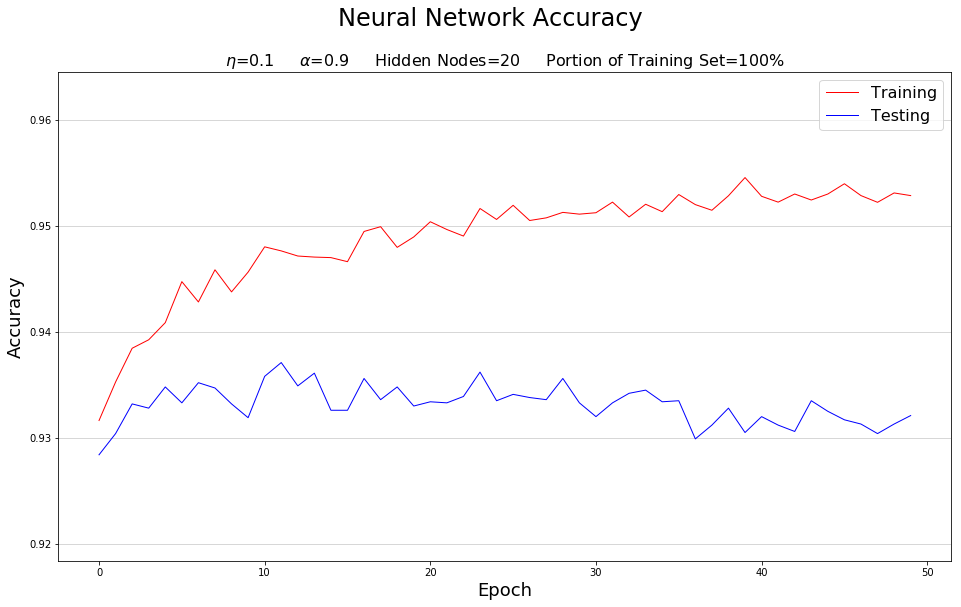

Experiment  1  Total Duration: 0:07:58.409505  Average Epoch Duration: 9.57

Experiment: 2  Fraction of training set: 100.0%
Network: (784, 50, 10)    Learning Rate: 0.1     Momentum: 0.9 


Max accuracy: Training: 0.98505, Testing: 0.9625
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  5864     0    10     2     4     1     3     4    33     2
1     3  6674    28     7     9     2     1     5    10     3
2    12     7  5882     4    10     1     4     7    28     3
3     6     0    47  5978     4    12     1    13    47    23
4     4     9     9     1  5770     0     6     4     9    30
5    20     1    10    32     4  5315    10     2    17    10
6    20     5    15     0     5    12  5837     1    22     1
7     1     8    28     3     8     0     0  6171     7    39
8    13    10     8     3     4    12     2     1  5794     4
9    20     2     7    26    47     8     0    16    30  5793

Testing Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  968     1    1    0    0    0    3    2    5    0
1    1  1121    3    2    0    1    2    1    4    0
2    7     2  981    4    6    2    4    8   17    1
3  

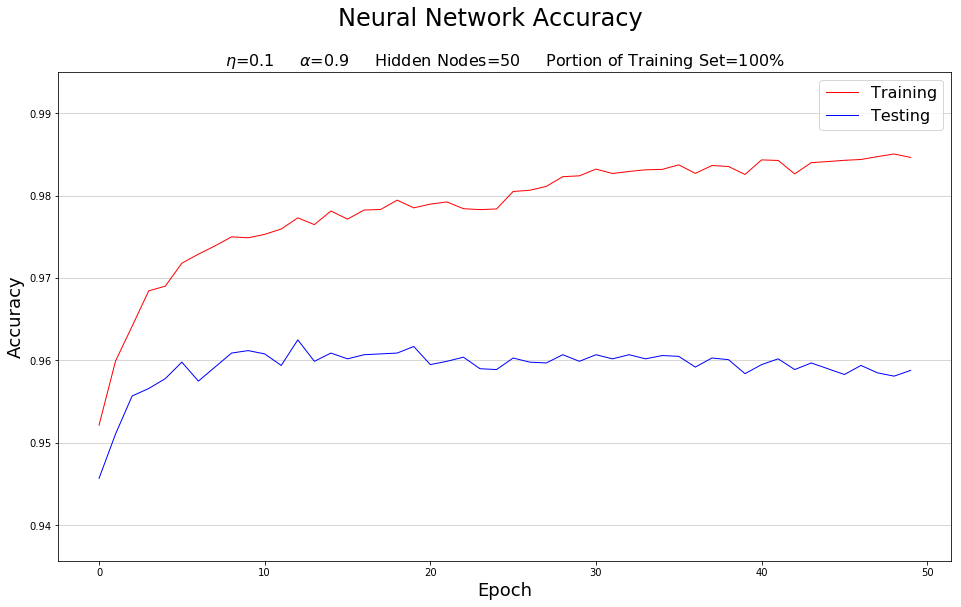

Experiment  2  Total Duration: 0:23:41.918050  Average Epoch Duration: 28.44

Experiment: 3  Fraction of training set: 100.0%
Network: (784, 100, 10)   Learning Rate: 0.1     Momentum: 0.9 


Max accuracy: Training: 0.99465, Testing: 0.9689
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  5889     0     0     3     0     1     2     0    27     1
1     0  6727     3     1     2     1     0     1     6     1
2     7     3  5924     2     1     2     0     1    18     0
3     0     0    11  6057     1     7     1    10    35     9
4     1     0     3     1  5826     0     0     0     6     5
5     1     0     3    18     0  5366     7     1    24     1
6     1     0     1     0     1     0  5905     0    10     0
7     0     3     5     1     2     0     1  6237     7     9
8     2     0     1     1     1     1     2     0  5841     2
9     2     0     2     4     4     2     0     7    21  5907

Testing Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  964     0    1    1    0    1    2    1   10    0
1    0  1120    4    3    0    1    2    1    4    0
2    5     2  988    2    1    0    3    7   21    3
3  

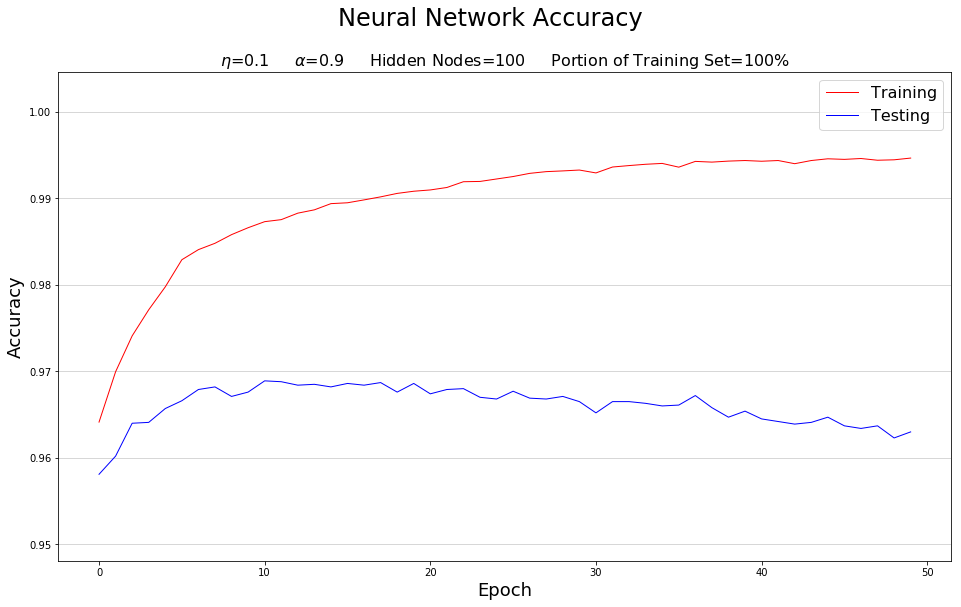

Experiment  3  Total Duration: 0:30:44.900426  Average Epoch Duration: 36.90

Experiment: 4  Fraction of training set: 100.0%
Network: (784, 100, 10)   Learning Rate: 0.1     Momentum: 0   


Max accuracy: Training: 0.9951166666666666, Testing: 0.9779
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  5902     0     3     1     2     3     4     0     6     2
1     2  6679    15    12     6     1     2     7    11     7
2     7     4  5937     1     2     0     0     4     1     2
3     0     0     4  6100     0     5     0     7     5    10
4     1     2     3     0  5821     0     2     2     0    11
5     4     2     4     5     2  5395     3     1     2     3
6     8     1     0     0     6     2  5895     0     6     0
7     0     3    12     0     6     0     0  6233     1    10
8     3     3     3     0     0     1     2     0  5835     4
9     7     2     1     3     6     7     0    11     2  5910

Testing Confusion Matrix:
     0     1     2    3    4    5    6    7    8    9
0  969     0     1    2    1    1    2    1    3    0
1    0  1115     4    4    1    2    2    2    5    0
2    1     3  1013    4    1    0    1    

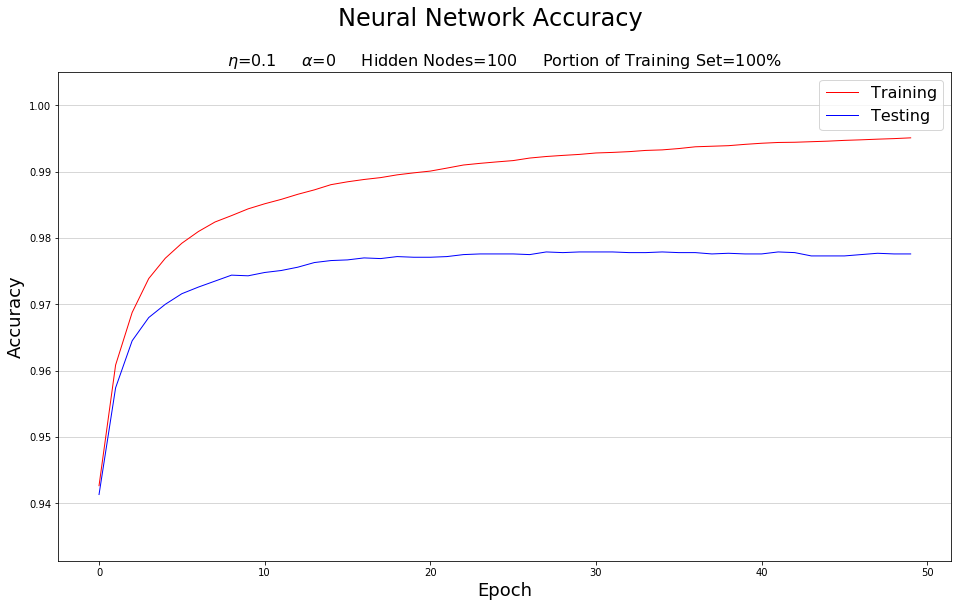

Experiment  4  Total Duration: 0:23:25.277949  Average Epoch Duration: 28.11

Experiment: 5  Fraction of training set: 100.0%
Network: (784, 100, 10)   Learning Rate: 0.1     Momentum: 0.25


Max accuracy: Training: 0.9956666666666667, Testing: 0.9742
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  5915     0     0     0     0     0     1     0     4     3
1     1  6675    16     9     7     1     0     7    20     6
2     2     1  5942     0     1     0     0     6     4     2
3     0     0     4  6102     0     2     0     6    11     6
4     1     5     5     0  5818     0     1     2     5     5
5     3     2     2     5     1  5391     3     0    10     4
6     4     2     0     0     1     3  5897     0    11     0
7     0     3     9     1     4     0     0  6234     5     9
8     1     4     1     0     0     0     0     0  5844     1
9     3     1     1     1     4     1     0     9     7  5922

Testing Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  969     0    1    1    2    0    1    1    5    0
1    0  1118    3    4    0    1    2    2    5    0
2    5     2  998    2    1    1    3    8   

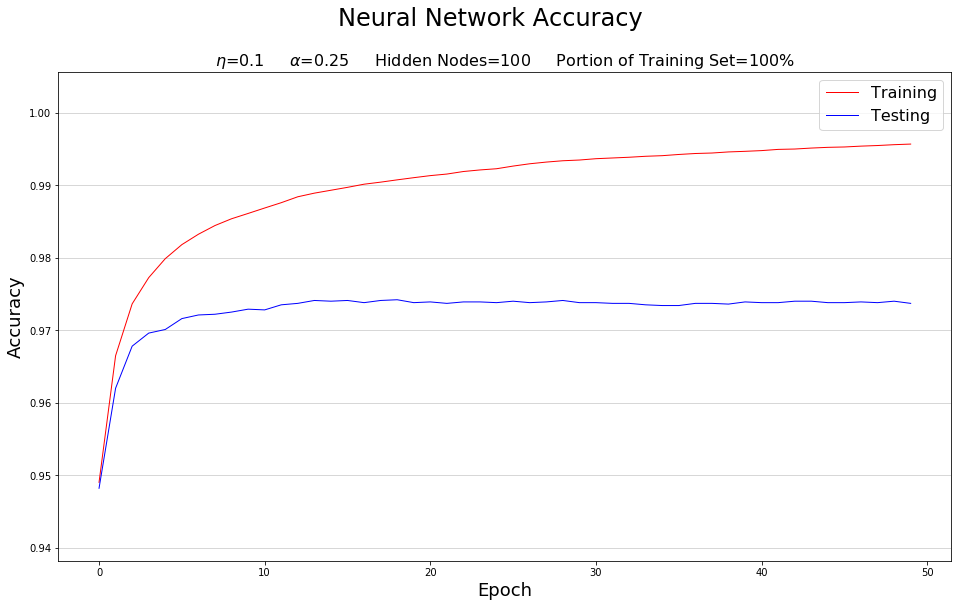

Experiment  5  Total Duration: 0:27:02.688128  Average Epoch Duration: 32.45

Experiment: 6  Fraction of training set: 100.0%
Network: (784, 100, 10)   Learning Rate: 0.1     Momentum: 0.5 


Max accuracy: Training: 0.99645, Testing: 0.9753
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  5908     1     1     0     0     2     4     0     5     2
1     2  6709     9     5     1     0     0     4     8     4
2     5     2  5939     1     1     1     1     3     3     2
3     1     0     2  6108     0     4     0     5     6     5
4     2     1     5     0  5819     0     2     1     4     8
5     3     1     4     5     1  5389    12     1     2     3
6     5     0     0     1     3     1  5903     0     5     0
7     1     4     5     2     0     0     0  6244     4     5
8     2     1     1     2     0     1     1     0  5841     2
9     5     1     0     4     2     3     1     3     3  5927

Testing Confusion Matrix:
     0     1     2    3    4    5    6    7    8    9
0  966     1     1    0    1    2    5    2    2    0
1    0  1121     3    3    0    1    2    1    4    0
2    2     4  1004    3    0    0    1   11    6    1

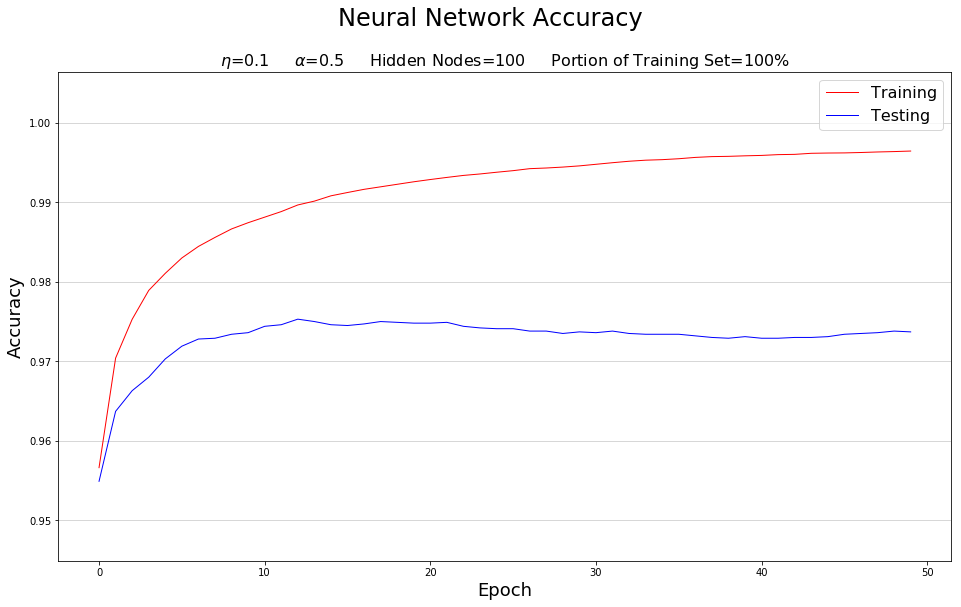

Experiment  6  Total Duration: 0:25:55.837622  Average Epoch Duration: 31.12

Experiment: 7  Fraction of training set: 25.0%
Network: (784, 100, 10)   Learning Rate: 0.1     Momentum: 0.9 


Max accuracy: Training: 0.9986666666666667, Testing: 0.9595
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  1503     0     0     0     0     0     0     0     2     1
1     0  1692     1     0     0     0     0     0     0     1
2     0     0  1404     0     0     0     0     0     0     0
3     0     0     1  1508     1     0     0     0     0     0
4     0     0     0     0  1437     0     0     0     0     0
5     2     0     0     1     0  1346     1     0     1     0
6     0     0     2     0     0     0  1510     0     1     0
7     0     0     0     0     0     0     0  1626     0     0
8     0     0     0     0     0     0     0     0  1470     0
9     0     0     1     4     0     0     0     0     0  1484

Testing Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  965     0    4    0    1    2    5    1    2    0
1    1  1123    2    3    0    1    2    0    3    0
2    8     7  953   17    5    0    3    7   

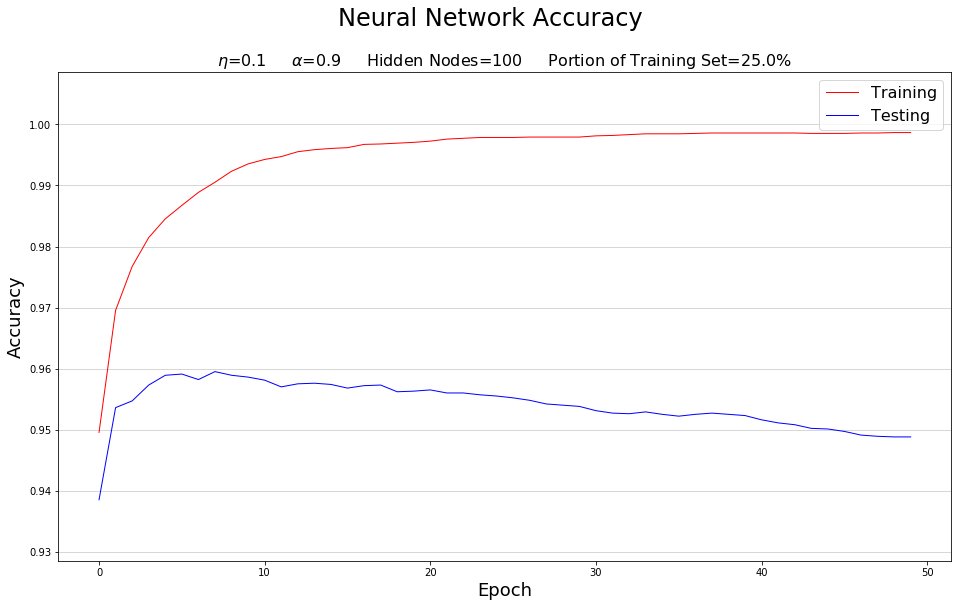

Experiment  7  Total Duration: 0:06:46.497206  Average Epoch Duration: 8.13

Experiment: 8  Fraction of training set: 50.0%
Network: (784, 100, 10)   Learning Rate: 0.1     Momentum: 0.9 


Max accuracy: Training: 0.9975666666666667, Testing: 0.9667
Training Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  2953     0     1     0     1     0     1     0     9     0
1     0  3318     5     0     0     0     0     3     1     0
2     0     0  3017     1     0     0     0     0     3     0
3     0     1     1  3010     2     0     0     0     6     2
4     0     0     0     0  2961     0     1     0     1     0
5     0     0     0     0     0  2640     0     0     3     1
6     0     0     1     0     0     0  2946     0     0     0
7     0     0     3     0     0     0     0  3141     1     3
8     0     0     0     0     0     0     0     0  2943     0
9     2     0     1     5     1     1     0     1    11  2998

Testing Confusion Matrix:
     0     1    2    3    4    5    6    7    8    9
0  962     0    1    0    1    2    3    3    4    4
1    0  1112    5    2    1    1    3    1   10    0
2    3     2  989   10    1    0    5    4   

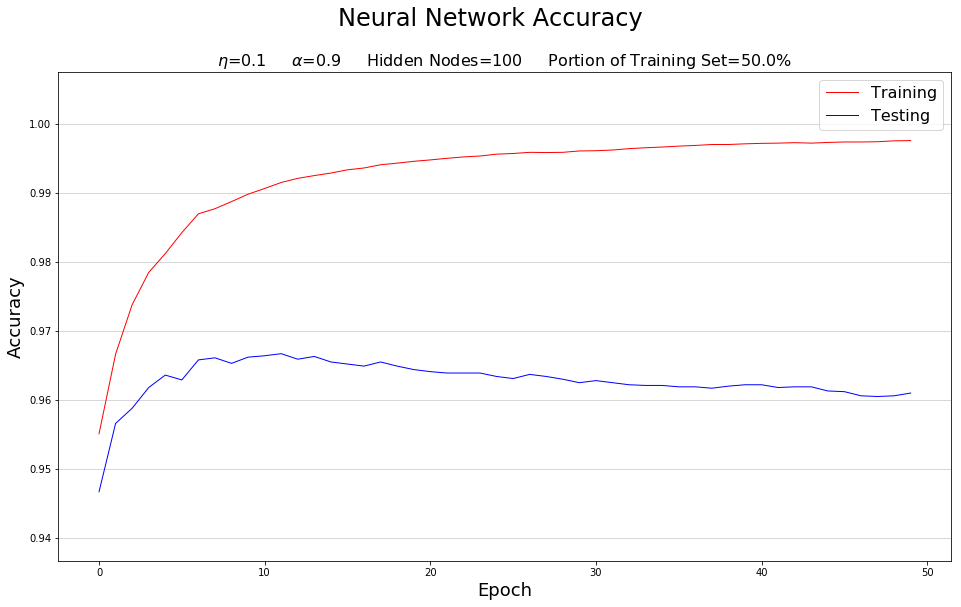

Experiment  8  Total Duration: 0:15:30.921335  Average Epoch Duration: 18.62



In [122]:
experiments = [
    ((20,), 0.1, 0.9, 1),
    ((50,), 0.1, 0.9, 1),
    ((100,), 0.1, 0.9, 1),
    ((100,), 0.1, 0, 1),
    ((100,), 0.1, 0.25, 1),
    ((100,), 0.1, 0.5, 1),
    ((100,), 0.1, 0.9, 0.25),
    ((100,), 0.1, 0.9, 0.5)
]

f = FloatProgress(min=0, max=100, description='Experiments Progress:', bar_style='success')
display(f)

log = {}

for exp_number, (num_hidden, eta, alpha, frac) in enumerate(experiments, start=1):
    start = datetime.now()
    log[exp_number] = {
            'experiment_number': exp_number,
            'eta': eta,
            'alpha': alpha,
            'frac': frac,
            'num_hidden': num_hidden,
            'training_accuracy': [],
            'testing_accuracy': [],
            'max_train_accuracy': 0,
            'max_test_accuracy': 0,
            'train_cm': np.zeros((num_classes, num_classes), dtype=np.int),
            'test_cm': np.zeros((num_classes, num_classes), dtype=np.int)
        }

    print('Experiment: {}  Fraction of training set: {}%'.format(exp_number, frac*100.0))

    X_train, y_train, X_test, y_test = get_train_test(train, test, frac)
    
    fit(log[exp_number], X_train, y_train, X_test, y_test)
    end = datetime.now()
    
    log[exp_number]['max_train_accuracy'] = max(log[exp_number]['training_accuracy'])
    log[exp_number]['max_test_accuracy'] = max(log[exp_number]['testing_accuracy'])
    
    print('Max accuracy: Training: {}, Testing: {}'.format(log[exp_number]['max_train_accuracy'],
                                                           log[exp_number]['max_test_accuracy']))
    
    print('Training Confusion Matrix:\n'
          '{}\n\n'
          'Testing Confusion Matrix:\n'
          '{}\n\n'
          .format(log[exp_number]['train_cm'], log[exp_number]['test_cm']))
    
    plot_accuracy_graphs(log[exp_number])
    
    print('Experiment {:>2}  Total Duration: {}  Average Epoch Duration: {:.2f}\n'
          .format(exp_number, end - start, (end - start).total_seconds() / num_epochs))    
    f.value += (1/len(experiments) * 100)